In [3]:
import sys
sys.path.append("../")
import matplotlib.pyplot as plt

In [4]:
import scanpy as sc
import pandas as pd
import numpy as np

# Load Observed Data

In [5]:
Xad = sc.read_h5ad("../../Data/echidna3/Tumor2_X.h5ad")
Xad

AnnData object with n_obs × n_vars = 2337 × 27762
    obs: 'celltypes', 'celltypes_RNA', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'original_total_counts', 'log10_original_total_counts', 'leiden'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'celltypes_RNA_colors', 'celltypes_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [6]:
Wdf = pd.read_csv("../../Data/echidna3/Tumor2_W.csv")
Wdf.set_index("Unnamed: 0", inplace=True)
Wdf.index.name = "gene"
Wdf.head()

,0
gene,
A3GALT2,10.522400
AADACL3,12.252164
AADACL4,12.252164
ABCA4,11.080183
ABCB10,11.838389


In [7]:
DNA = pd.read_csv("../../Data/echidna3/DNA_bin_counts_matrix.txt", sep='\t')

In [8]:
from echidna.utils import *

/Users/mingxuanzhang/anaconda3/envs/work3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
X_obs, W_obs, z_obs, pi_obs = prepare_input(Xad, Wdf, sample_name=None, 
                                            timepoints=['st'], n_subsamples=3000, device="cpu")
print(X_obs.shape)
print(W_obs.shape)
print(z_obs.shape)
print(pi_obs.shape)

torch.Size([2337, 27762])
torch.Size([27762])
torch.Size([2337])
torch.Size([10])


# Fit the model and simulate data

In [17]:
from echidna.model import Echidna
from echidna.train import train_Echidna
from echidna.utils import ModelConfig
from echidna.params import *
from echidna.eval import *

In [11]:
config = ModelConfig()
config.num_cells = X_obs.shape[1]
config.num_genes = X_obs.shape[-1]
config.num_clusters = pi_obs.shape[0]
config.q_corr_init = 0.1
config.q_shape_rate_scaler = 10.0
config.eta_mean_init = 11.0
config.lkj_concentration = 0.5

In [12]:
echidna = Echidna(config, mode='ST', device='cpu')
echidna, losses = train_Echidna(echidna, X_obs, W_obs, pi_obs, z_obs, lr=0.1, n_epochs=200)

100%|██████████| 200/200 [01:22<00:00,  2.42it/s]


In [14]:
eta_ground_truth = eta_posterior_estimates(echidna, X_obs, W_obs, pi_obs, z_obs, num_samples=10000)
c_ground_truth = c_posterior_estimates(eta=eta_ground_truth, mt=False)
cov_ground_truth = cov_posterior_estimate(inverse_gamma=True)

In [16]:
print(eta_ground_truth.shape)
print(c_ground_truth.shape)
print(cov_ground_truth.shape)

torch.Size([10, 27762])
torch.Size([10, 27762])
(10, 10)


In [18]:
library_size = X_obs.sum(-1, keepdim=True) * 1e-5
X_simulated = sample_X(X_obs.numpy(), c_ground_truth, eta_ground_truth, z_obs.numpy(), library_size)
X_simulated.shape

(2337, 27762)

In [22]:
W_simulated = sample_W(pi=pi_obs, eta=eta_ground_truth)
W_simulated.shape

(27762,)

# Fit with simulated data

In [28]:
echidna = Echidna(config, mode='ST', device='cpu')
echidna, losses = train_Echidna(echidna, torch.tensor(X_simulated), torch.tensor(W_simulated), pi_obs, z_obs, lr=0.1, n_epochs=200)

100%|██████████| 200/200 [00:46<00:00,  4.31it/s]


In [29]:
eta_learned = eta_posterior_estimates(echidna, torch.tensor(X_simulated), torch.tensor(W_simulated), pi_obs, z_obs, num_samples=10000)
c_learned = c_posterior_estimates(eta=eta_ground_truth, mt=False)
cov_learned = cov_posterior_estimate(inverse_gamma=True)

In [30]:
from scipy.stats import linregress
import seaborn as sns

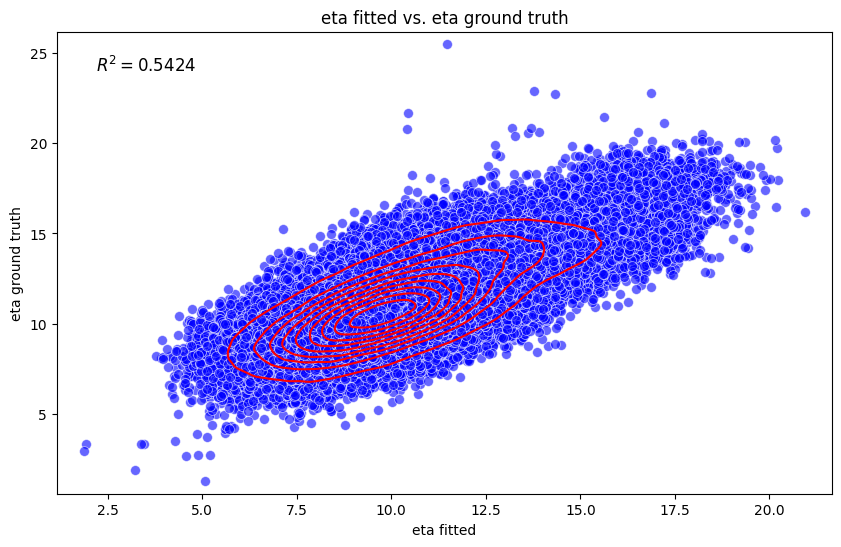

In [45]:
x = eta_learned.flatten()
y = eta_ground_truth.flatten()

# Perform linear regression to get the R^2 value
slope, intercept, r_value, p_value, std_err = linregress(x, y)
r_squared = r_value**2

# Create a DataFrame
data = pd.DataFrame({'eta_learned': x, 'eta_ground': y})

# Plot the scatter plot
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(data=data, x='eta_learned', y='eta_ground', s=50, color='blue', alpha=0.6)

# Overlay the contour plot
contour = sns.kdeplot(data=data, x='eta_learned', y='eta_ground', levels=10, color='red', linewidths=1.5)

# Annotate the R^2 value on the plot
plt.text(0.05, 0.95, f'$R^2 = {r_squared:.4f}$', transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top')

# Show plot
plt.title('eta fitted vs. eta ground truth')
plt.xlabel('eta fitted')
plt.ylabel('eta ground truth')
plt.show()

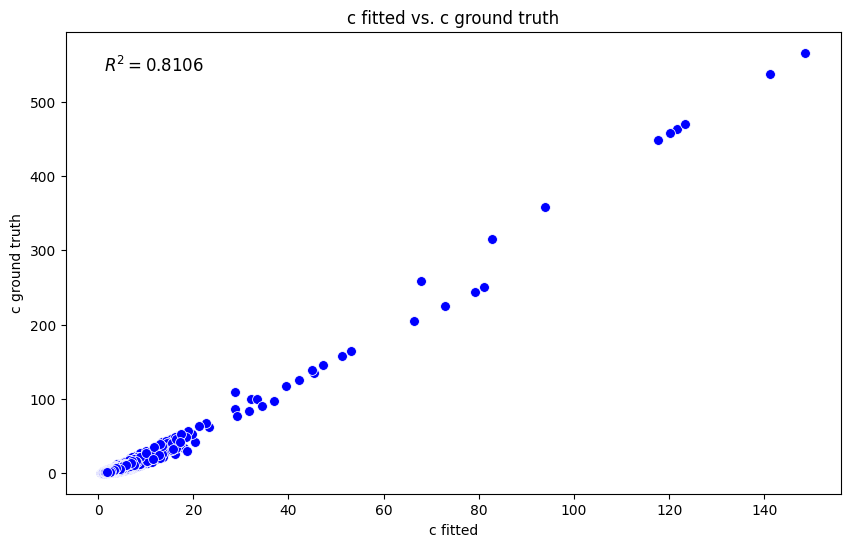

In [47]:
x = c_learned.flatten()
y = c_ground_truth.flatten()
slope, intercept, r_value, p_value, std_err = linregress(x, y)
r_squared = r_value**2

# Create a DataFrame
data = pd.DataFrame({'c_learned': x, 'c_ground': y})

# Plot the scatter plot
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(data=data, x='c_learned', y='c_ground', s=50, color='blue')

# Overlay the contour plot
#contour = sns.kdeplot(data=data, x='c_learned', y='c_ground', levels=10, color='red', linewidths=1.5)

# Annotate the R^2 value on the plot
plt.text(0.05, 0.95, f'$R^2 = {r_squared:.4f}$', transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top')

# Show plot
plt.title('c fitted vs. c ground truth')
plt.xlabel('c fitted')
plt.ylabel('c ground truth')
plt.show()

In [38]:
from scipy.cluster.hierarchy import linkage, leaves_list

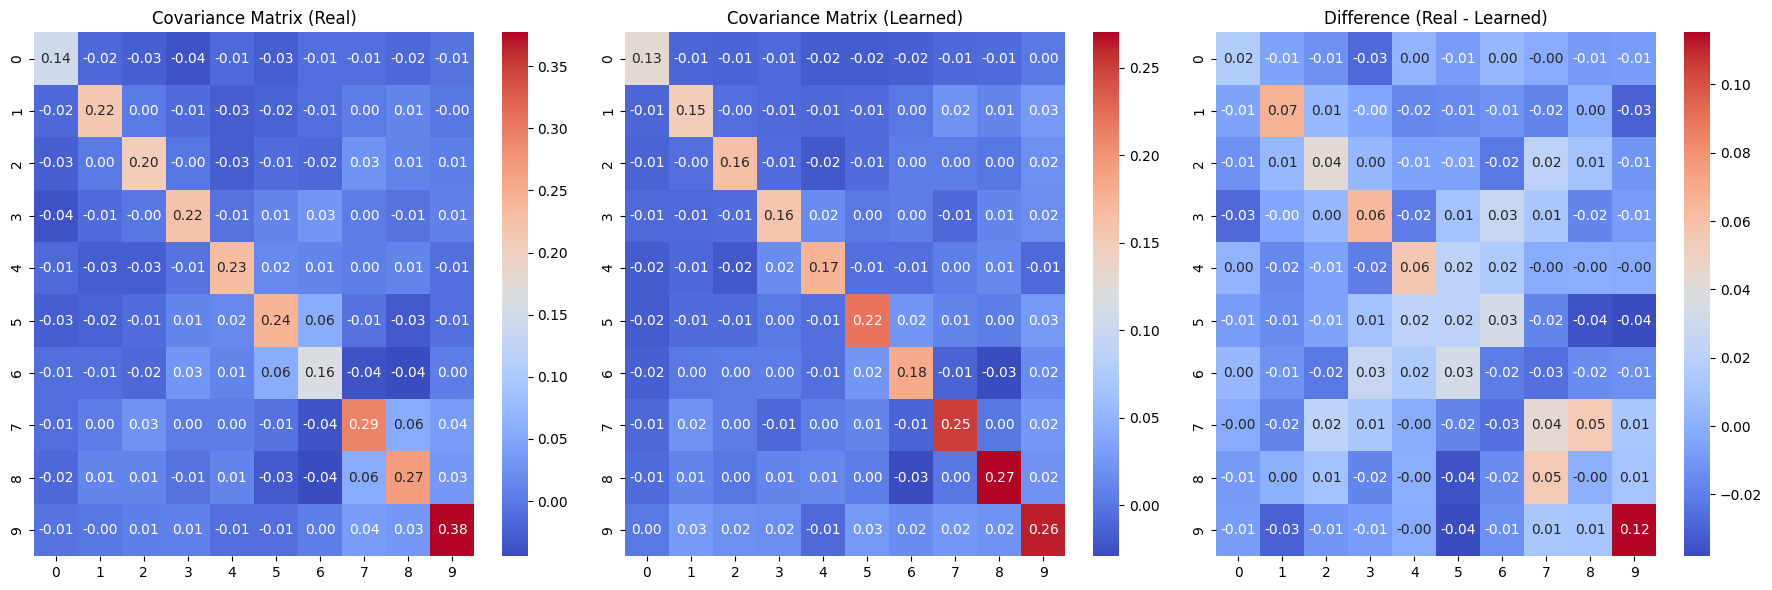

In [43]:
# Calculate the difference matrix
cov_matrix_diff = cov_ground_truth - cov_learned
cov_matrix_real = cov_ground_truth
cov_matrix_simulated = cov_learned

# Calculate the difference matrix
cov_matrix_diff = cov_matrix_real - cov_matrix_simulated

# Create heatmaps
plt.figure(figsize=(18, 6))

# Plot the real covariance matrix
plt.subplot(1, 3, 1)
sns.heatmap(cov_matrix_real, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Covariance Matrix (Real)')

# Plot the simulated covariance matrix
plt.subplot(1, 3, 2)
sns.heatmap(cov_matrix_simulated, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Covariance Matrix (Learned)')

# Plot the difference between the two covariance matrices
plt.subplot(1, 3, 3)
sns.heatmap(cov_matrix_diff, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Difference (Real - Learned)')

plt.tight_layout()
plt.show()